In [1]:
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn import plotting
from ipywidgets import interact, widgets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket
import os

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['simnibs_path'] = os.path.join(p['datd'], 'SIMNIBS_output')

# Load up summary data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))

All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}
subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 24, 25, 26, 27]

stim_intensities = []
hemisphere_stimulated = []
for ss in subs:
    stim_intensities.append(All_metadata[ss]['Stim Intensity'])
    hemisphere_stimulated.append(All_metadata[ss]['Hemisphere stimulated'])
stim_dIdt = [round((a / 60) * 87 *1e6) for a in stim_intensities]


In [2]:
# Function to load nifty
def load_nii_file(fpath, T1):
    nii_img = nib.load(fpath)
    if nii_img.shape[0] != 320:
        nii_img = resample_to_img(fpath, T1, interpolation='nearest')
    data = nii_img.get_fdata()
    return data

# Function to compute average from mask
def calculate_average_over_mask(whole_brain, mask):
    masked_data = whole_brain[mask > 0]
    #print(masked_data.shape)
    average_value = masked_data.max() 
    #########print(average_value)
    return average_value

In [3]:
## Create ROIs for sub24
def segregate_rois(roi_path, t1_path, subfoldpath):
    roi_loader = nib.load(t1_path)
    roi_data = load_nii_file(roi_path, t1_path)

    mid_x = roi_data.shape[0] // 2 - 6 # This was found by brute-force search
    
    rois = {'V1': 1, 'V2d': 2, 'V3d': 3, 'V3AB': 4}
    segregated_rois = {roi: {'left': None, 'right': None} for roi in rois}
    
    for roi_name, roi_value in rois.items():
        roi_mask = roi_data == roi_value
        lh = roi_mask.copy()
        rh = roi_mask.copy()
        lh[:mid_x, :, :] = 0
        rh[mid_x:, :, :] = 0
        lh_uint8 = lh.astype(np.uint8)
        rh_uint8 = rh.astype(np.uint8)
        #segregated_rois[roi_name]['left'] = lh
        #segregated_rois[roi_name]['right'] = rh
        lft_img = nib.Nifti1Image(lh_uint8, affine=roi_loader.affine)
        rght_img = nib.Nifti1Image(rh_uint8, affine=roi_loader.affine)
        nib.save(lft_img, f"{subfoldpath}/lh.{roi_name}.nii.gz")
        nib.save(rght_img, f"{subfoldpath}/rh.{roi_name}.nii.gz")
    return segregated_rois

subfoldpath = f"{p['simnibs_path']}/sub24"
t1_path = f"{subfoldpath}/T1.nii"
roi_path = f"{subfoldpath}/ROIs_V1-4-in-volume.nii.gz"
t1_data = load_nii_file(t1_path, t1_path)
roi_total = load_nii_file(roi_path, t1_path)

segregated_rois = segregate_rois(roi_path, t1_path, subfoldpath)

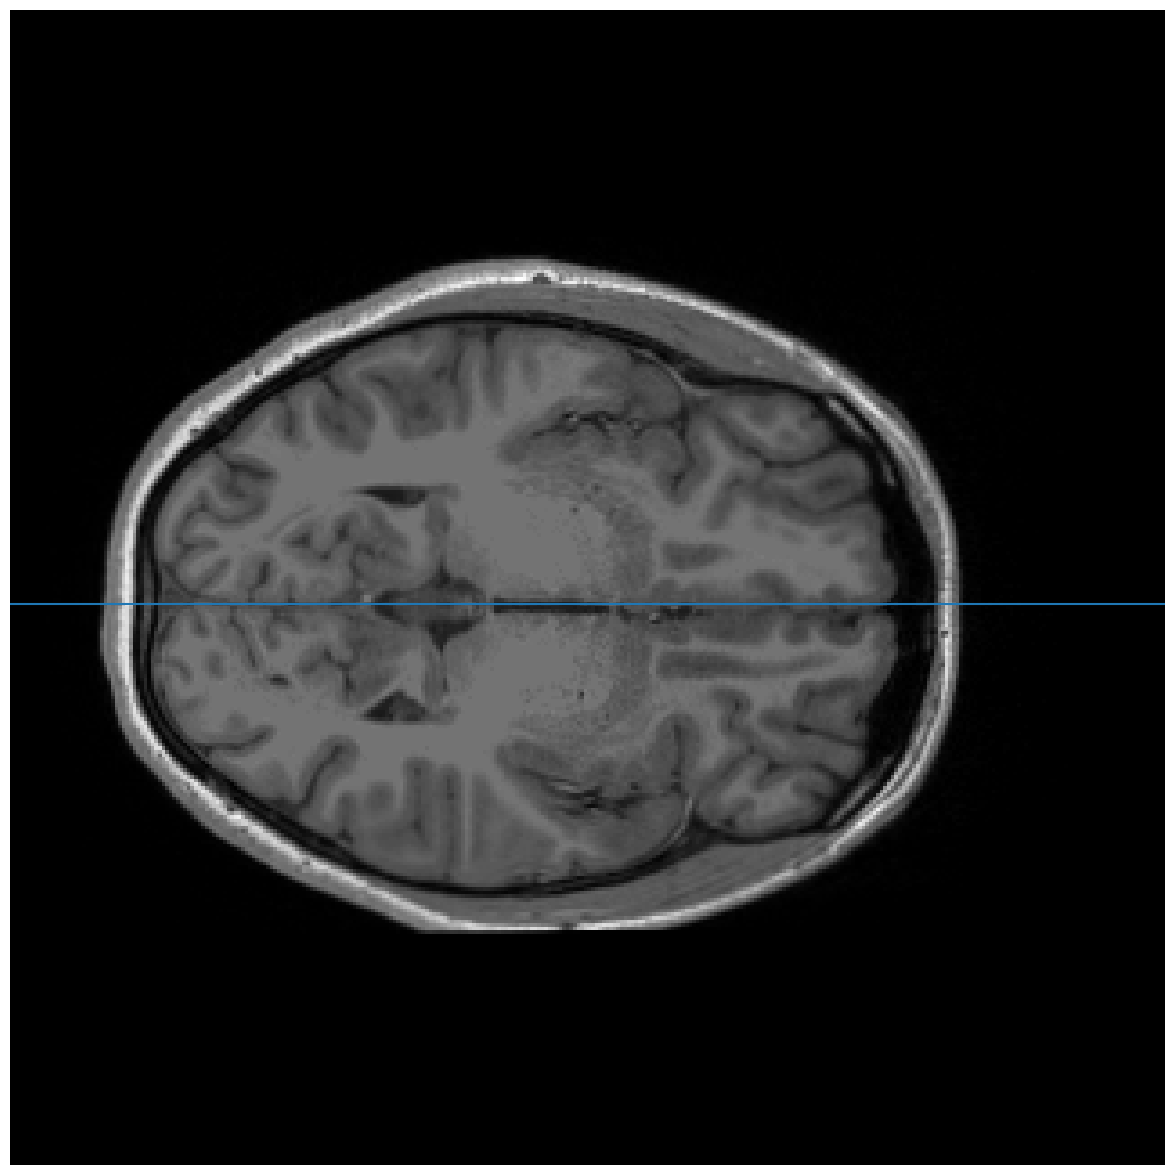

In [5]:
slice_toplot = 140
slice_num = roi_total.shape[0] // 2 -5
t1_plot = t1_data.copy()
#t1_plot[slice_num:, :, :] = 0
#slice_num = slice_num-1
#t1_plot = t1_data

roi_mask = roi_total == 2
plt.figure(figsize=(15, 15))
plt.imshow(t1_plot[:, slice_toplot, :], cmap='gray', origin='lower')
#plt.imshow(roi_mask[:, slice_toplot, :], cmap='hot', alpha=0.5, origin='lower')  # Overlay ROI
#plt.imshow(segregated_rois['V3d']['right'][:, slice_toplot, :], cmap='hot', alpha=0.5, origin='lower')
plt.axhline(y=slice_num)
#plt.title(f"{roi_name} - {hemisphere} Hemisphere")
plt.axis('off')
plt.show()

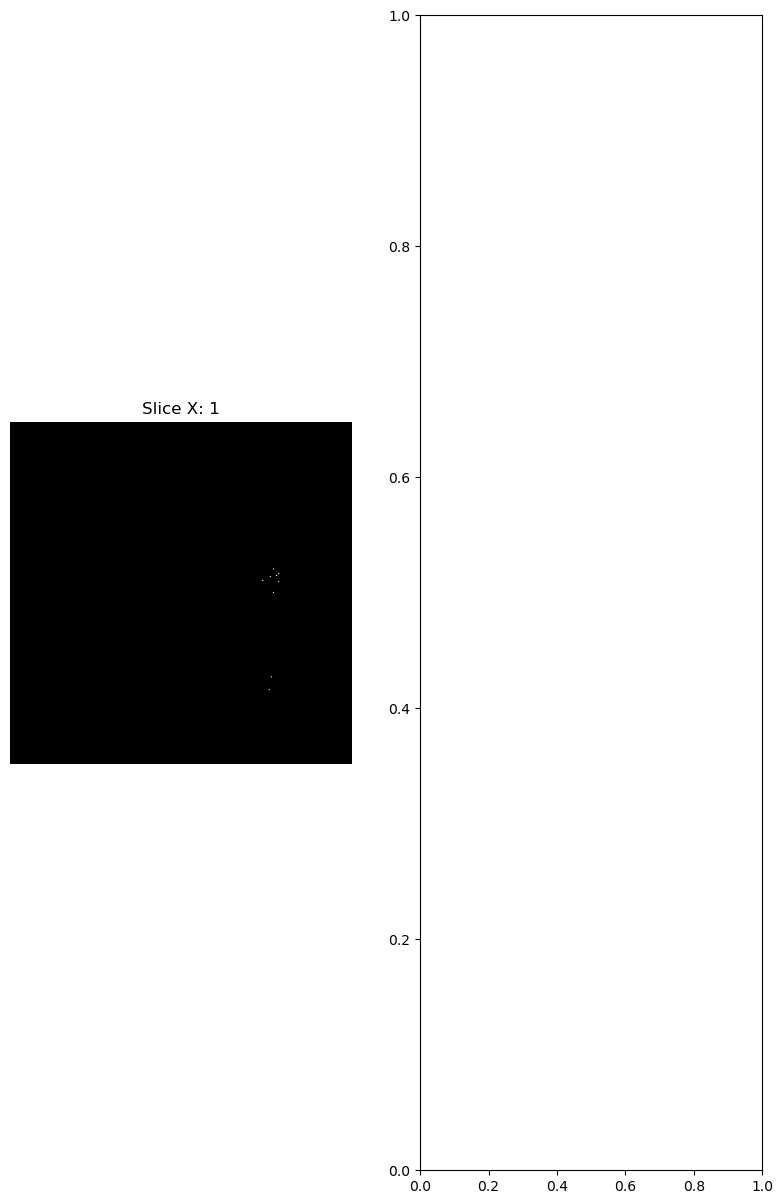

interactive(children=(IntSlider(value=1, description='Slice X:', max=319), IntSlider(value=1, description='Sli…

<function __main__.update_plot(slice_x, slice_y, slice_z)>

In [11]:
slice_x = 1
slice_y = 1
slice_z = 1
def update_plot(slice_x, slice_y, slice_z):
    plt.figure(figsize=(15, 15))
    # Subplot for slice_x
    plt.subplot(131)
    plt.imshow(t1_plot[:, slice_x, :], cmap='gray', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(132)
    plt.imshow(t1_plot[slice_y, :, :], cmap='gray', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(133)
    plt.imshow(t1_plot[:, :, slice_z], cmap='gray', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')
    plt.show()
# Create widgets for each slice
slice_x_widget = widgets.IntSlider(min=0, max=t1_data.shape[0] - 1, value=slice_x, description='Slice X:')
slice_y_widget = widgets.IntSlider(min=0, max=t1_data.shape[1] - 1, value=slice_y, description='Slice Y:')
slice_z_widget = widgets.IntSlider(min=0, max=t1_data.shape[2] - 1, value=slice_z, description='Slice Z:')
# Create an interactive plot
interact(update_plot, slice_x=slice_x_widget, slice_y=slice_y_widget, slice_z=slice_z_widget)

In [8]:
data = {}
meanarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
allvalsarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
for idx, sub in enumerate(subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }

    data[sub_id] = {roi_name: load_nii_file(path, file_paths['T1'])
                    for roi_name, path in file_paths.items()}
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    
    for roi_name, path in file_paths.items():
        roi_data = load_nii_file(path, f"{subfoldpath}/T1.nii")
        allvalsarray[roi_name].extend(metric_data[roi_data>0].flatten())
        mean_value = calculate_average_over_mask(metric_data, roi_data)
        meanarray[roi_name].append(mean_value)

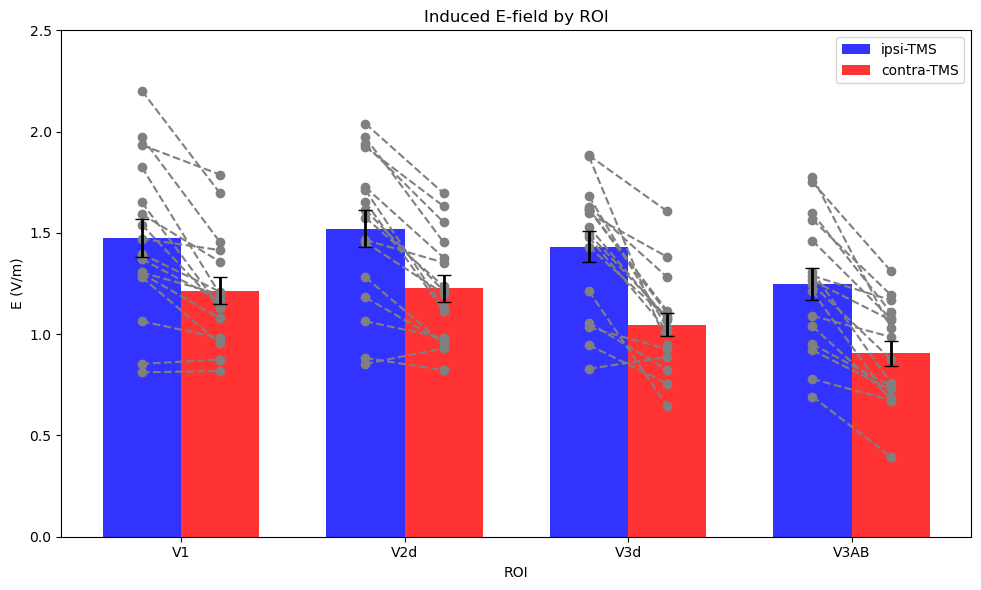

In [10]:
means = {roi: np.mean(values) for roi, values in meanarray.items()}
std_errors = {roi: np.std(values) / np.sqrt(len(values)) for roi, values in meanarray.items()}
roi_list = ['V1', 'V2d', 'V3d', 'V3AB']

fig, ax = plt.subplots(figsize=(10, 6))
n_groups = len(means) // 2
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, roi in enumerate(roi_list):
    lh_mean = meanarray[f'lh{roi}']
    rh_mean = meanarray[f'rh{roi}']
    lh_x = index[i] - bar_width/2
    rh_x = lh_x + bar_width
    ax.plot([lh_x + bar_width/2, rh_x + bar_width/2], [lh_mean, rh_mean], 'grey', linestyle='--', marker='o')


left_bars = ax.bar(index, [means[f'lh{roi}'] for roi in roi_list],
                   bar_width, alpha=opacity, color='b',
                   yerr=[std_errors[f'lh{roi}'] for roi in roi_list],
                   label='ipsi-TMS', error_kw={'elinewidth':2, 'capsize':5})

right_bars = ax.bar(index + bar_width, [means[f'rh{roi}'] for roi in roi_list],
                    bar_width, alpha=opacity, color='r',
                    yerr=[std_errors[f'rh{roi}'] for roi in roi_list],
                    label='contra-TMS', error_kw={'elinewidth':2, 'capsize':5})

ax.set_xlabel('ROI')
ax.set_ylabel('E (V/m)')
ax.set_title('Induced E-field by ROI')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(roi_list)
ax.legend()

# Adding a grid, setting the limit and making layout tight
#ax.yaxis.grid(True)
ax.set_ylim([0, max(means.values()) + max(std_errors.values()) * 3])  # Adjust the y-axis limit to show error bars
plt.tight_layout()
plt.ylim([0, 2.5])
# Show the plot
#plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/efield_induced_max.eps', format = 'eps', dpi = 1200)
plt.show()

In [16]:
for i, roi in enumerate(roi_list):
    for jj in range(len(subs)):
        sub_id = subs[jj]
        #meanarray[roi_name]
        lh_mean = meanarray[f'lh{roi}'][jj]
        rh_mean = meanarray[f'rh{roi}'][jj]
        if rh_mean > lh_mean:
            print(subs[jj], roi, lh_mean, rh_mean)

6 V1 0.8534456491470337 0.8746649026870728
10 V1 0.8116142153739929 0.8179522752761841
6 V2d 0.8534456491470337 0.9302440285682678
6 V3d 0.8292014002799988 0.8872819542884827


In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
ax[0].hist(allvalsarray['lhV1'], bins = 100, range = (0.1, 2))
ax[1].hist(allvalsarray['rhV1'], bins = 100, range = (0.1, 2))
ax[0].set_title('lhV1')
ax[1].set_title('rhV1')
ax[0].set_ylim([0, 500])
ax[1].set_ylim([0, 500])
ax[0].set_xlabel('E (V/m)')
ax[1].set_xlabel('E (V/m)')
plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/hist_efield_V1_sub01.eps', format = 'eps', dpi = 1200)
plt.show()
#plt.xlim([0.1, 1])

In [ ]:
print(np.median(allvalsarray['lhV1']), np.median(allvalsarray['rhV1']))

In [ ]:
fig = plt.figure(figsize = (10, 10))
plt.hist(allvalsarray['lhV1'], bins = 100, range = (0.1, 2), density = True, color = 'blue', alpha = 0.5)
plt.hist(allvalsarray['rhV1'], bins = 100, range = (0.1, 2), density = True, color = 'red', alpha = 0.5)
plt.xlabel('E (V/m)')
plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/hist_efield_V1_something_sub01.eps', format = 'eps', dpi = 1200)
plt.show()

In [ ]:
plt.figure()
plt.plot(subs, meanarray['lhV1'], 'ro')
plt.plot(subs, meanarray['rhV1'], 'bo')

In [ ]:
sizearray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
Efieldarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
roi_list = ['T1', 'lhV1', 'rhV1', 'lhV2d', 'rhV2d', 'lhV3d', 'rhV3d', 'lhV3AB', 'rhV3AB']
for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
    sub = subs[idx]
    sub_id = f"sub{sub:02d}"
    for roi_name in roi_list:
        sizearray[roi_name].append(np.sum(data[sub_id][roi_name]))
        Efieldarray[roi_name].append(meanarray[roi_name][idx])

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))
axs = axs.flatten()
idx_plot = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]
for ax, roi_name in zip(axs, roi_list):
    #this_x = [sizearray[roi_name][i] for i in idx_plot]
    this_x = [stim_intensities]
    this_y = [Efieldarray[roi_name][i] for i in idx_plot]
    ax.scatter(this_x, this_y)
    ax.set_title(roi_name)
    ax.set_xlabel('Size')
    ax.set_ylabel('E-field')
plt.tight_layout()
plt.show()

In [ ]:
master_df = pd.read_csv('/d/DATC/datc/MD_TMS_EEG/analysis/meta_analysis/master_df.csv')
master_df.head()

In [ ]:
tempt

In [ ]:
slcnum = 140
plt.figure(figsize=(10, 6))
plt.imshow(data['sub03']['T1'][:, slcnum, :], cmap='gray')
#plt.imshow(data['sub01']['lhV1'][:, slcnum, :], cmap = 'gray', alpha = 0.5)
plt.imshow(data['sub03']['lhV3AB'][:, slcnum, :], cmap = 'gray', alpha = 0.5)

plt.show()